In [1]:
import random
import gym
import numpy as np
from collections import deque

import torch
from torch import nn, optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ENV_NAME = "LunarLander-v2"

GAMMA = 0.9999
LEARNING_RATE = 0.0001

MEMORY_SIZE = 2**16
BATCH_SIZE = 32

EPSILON_MAX = 1.0
EPSILON_MIN = 0.00001
EPSILON_DECAY = 0.99999

In [3]:
class EnvModel(nn.Module):
    def __init__(self, observation_space, action_space):
        super().__init__()
        self.fc1 = nn.Linear(observation_space, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc_out = nn.Linear(24, action_space)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

In [4]:
class Dqn():
    def __init__(self, observation_space, action_space):
        self.observation_space = observation_space
        self.action_space = action_space
        self.model = EnvModel(observation_space, action_space)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.train_losses = []
        self.epsilon = EPSILON_MAX
        self.memory = deque(maxlen=MEMORY_SIZE)    
        
        
    def fit(self, state, q_values):
        self.optimizer.zero_grad()
        log_ps = self.model(state)
        loss = self.criterion(log_ps, q_values)
        loss.backward()
        self.optimizer.step()
 

    def predict_states(self, state):
        self.model.eval()
        with torch.no_grad():
            prediction = self.model(state)
        
        self.model.train()
        return prediction
    
    
    # todo - replace me with (, N)
    def predict(self, state):
        self.model.eval()
        with torch.no_grad():
            state = torch.from_numpy(state).float()
            prediction = self.model(state)
        
        self.model.train()
        return prediction.numpy()
    
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

        
    def get_action(self, state):  
        random_action = random.random() <= self.epsilon
        q_values = self.predict(state)
        return random.randint(0, self.action_space - 1) if random_action else np.argmax(q_values)
    
    
    def experience_replay(self):
        """
        this whole implementation feels very ham fisted, refactor
        """
        batch = random.sample(self.memory, min(BATCH_SIZE, len(self.memory)))

        # this feels very ham fisted...
        state_nexts = [state_next for _, _, _, state_next, _ in batch]
        state_nexts = torch.FloatTensor(state_nexts)
        q_next_states = self.predict_states(state_nexts)
        
        terminals = [t for _, _, _, _, t in batch]
        rewards = [r for _, _, r, _, _ in batch]
        
        state_rewards = torch.FloatTensor(rewards) if terminals else (torch.FloatTensor(rewards) + GAMMA * torch.max(q_next_states, dim=1))
        
        states = [state for state, _, _, _, _ in batch]
        states = torch.FloatTensor(states)
        
        actions = torch.LongTensor([a for _, a, _, _, _ in batch])
        
        q_values_predicted = self.predict_states(states)
        q_values_predicted[np.arange(0, len(batch)), actions] = state_rewards
        
        self.fit(states, q_values_predicted)

In [5]:
env = gym.make(ENV_NAME)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/Users/hamishdickson/miniconda3/envs/py36/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [6]:
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

print(observation_space, action_space)

8 4


In [7]:
epochs = 2000
exploration_rate = EPSILON_MAX

scores = []
final_rewards = []

dqn = Dqn(observation_space, action_space)

In [8]:
%%time

for run in range(epochs):
    step = 0
    state = env.reset()
    
    score = 0

    while True:
        step += 1
        action = dqn.get_action(state)
        
        state_next, reward, terminal, info = env.step(action)
        
        dqn.remember(state, action, reward, state_next, terminal)
        
        state = state_next
        
        score += reward        
        if terminal:
            print("Epoch: " + str(run + 1) + ", epsilon: " + str(dqn.epsilon) + ", steps: " + str(step) + ", reward: " + str(reward) + ", score: " + str(score))
            scores.append(score)
            final_rewards.append(reward)
            break
            
        dqn.experience_replay()
        
        dqn.epsilon *= EPSILON_DECAY
        dqn.epsilon = max(EPSILON_MIN, dqn.epsilon)

Epoch: 1, epsilon: 0.9993302210521057, steps: 68, reward: -100, score: -118.23873479960632
Epoch: 2, epsilon: 0.9982415391071936, steps: 110, reward: -100, score: -168.52328203030575
Epoch: 3, epsilon: 0.9972238467601702, steps: 103, reward: -100, score: -172.41891623534292
Epoch: 4, epsilon: 0.9964363470870565, steps: 80, reward: -100, score: -475.79443830478203
Epoch: 5, epsilon: 0.9950821079751485, steps: 137, reward: -100, score: -335.06849229000113
Epoch: 6, epsilon: 0.9939483550652328, steps: 115, reward: -100, score: -368.03544586095927
Epoch: 7, epsilon: 0.9932329662435201, steps: 73, reward: -100, score: -175.53273264882174
Epoch: 8, epsilon: 0.9923096843611222, steps: 94, reward: -100, score: -158.42379891996137
Epoch: 9, epsilon: 0.9910403341758119, steps: 129, reward: -100, score: -229.53953131134173
Epoch: 10, epsilon: 0.9902181078584358, steps: 84, reward: -100, score: -402.9111784812171
Epoch: 11, epsilon: 0.9894856138523562, steps: 75, reward: -100, score: -138.67910595

Epoch: 92, epsilon: 0.9156872155124786, steps: 96, reward: -100, score: -270.00571844200306
Epoch: 93, epsilon: 0.914744538529099, steps: 104, reward: -100, score: -346.0508207089638
Epoch: 94, epsilon: 0.9135652729678864, steps: 130, reward: -100, score: -375.7351051346383
Epoch: 95, epsilon: 0.9123875276860584, steps: 130, reward: -100, score: -136.52332815024985
Epoch: 96, epsilon: 0.9110381861574025, steps: 149, reward: -100, score: -150.44918147301019
Epoch: 97, epsilon: 0.910273231582156, steps: 85, reward: -100, score: -116.56661337569896
Epoch: 98, epsilon: 0.9093179415275869, steps: 106, reward: -100, score: -148.35505058427356
Epoch: 99, epsilon: 0.9085544313583158, steps: 85, reward: -100, score: -211.27401861453995
Epoch: 100, epsilon: 0.9079459007271758, steps: 68, reward: -100, score: -125.79691984646851
Epoch: 101, epsilon: 0.9069658435802225, steps: 109, reward: -100, score: -283.0792432012771
Epoch: 102, epsilon: 0.906294933768668, steps: 75, reward: -100, score: -67.5

Epoch: 181, epsilon: 0.8238053776806266, steps: 104, reward: -100, score: -154.67905207774623
Epoch: 182, epsilon: 0.8226610779566992, steps: 140, reward: -100, score: -311.6503621151978
Epoch: 183, epsilon: 0.8220114291019515, steps: 80, reward: -100, score: -120.77791894348456
Epoch: 184, epsilon: 0.8208039539754471, steps: 148, reward: -100, score: -582.4658241345464
Epoch: 185, epsilon: 0.8197375967858416, steps: 131, reward: -100, score: -343.2122299388965
Epoch: 186, epsilon: 0.8189264540911916, steps: 100, reward: -100, score: -171.86565082320922
Epoch: 187, epsilon: 0.8180588476244841, steps: 107, reward: -100, score: -513.6264567016892
Epoch: 188, epsilon: 0.8172902297716118, steps: 95, reward: -100, score: -206.35766206774386
Epoch: 189, epsilon: 0.8164406855245059, steps: 105, reward: -100, score: -159.86842547720005
Epoch: 190, epsilon: 0.8157143729398664, steps: 90, reward: -100, score: -146.25822916364942
Epoch: 191, epsilon: 0.8149316589910792, steps: 97, reward: -100, s

Epoch: 270, epsilon: 0.7415434697062817, steps: 95, reward: -100, score: -169.55109786368698
Epoch: 271, epsilon: 0.7407282162849212, steps: 111, reward: -100, score: -53.442452426081616
Epoch: 272, epsilon: 0.739543992849128, steps: 161, reward: -100, score: -203.67579210762713
Epoch: 273, epsilon: 0.7387678753090602, steps: 106, reward: -100, score: -336.7406218985895
Epoch: 274, epsilon: 0.7382361512238559, steps: 73, reward: -100, score: -108.74316616000868
Epoch: 275, epsilon: 0.7375130305670459, steps: 99, reward: -100, score: -121.87966175622635
Epoch: 276, epsilon: 0.7366727405670506, steps: 115, reward: -100, score: -229.41370278738796
Epoch: 277, epsilon: 0.7353405622308197, steps: 182, reward: -100, score: -267.922593921082
Epoch: 278, epsilon: 0.734664356634806, steps: 93, reward: -100, score: -472.0110996167909
Epoch: 279, epsilon: 0.7338713434687623, steps: 109, reward: -100, score: -170.8876923923508
Epoch: 280, epsilon: 0.7331378352729743, steps: 101, reward: -100, scor

Epoch: 359, epsilon: 0.6522403586767754, steps: 214, reward: -100, score: -242.31714559660517
Epoch: 360, epsilon: 0.6516210214710962, steps: 96, reward: -100, score: -49.58167354773738
Epoch: 361, epsilon: 0.6510673761672061, steps: 86, reward: -100, score: -137.37231955983088
Epoch: 362, epsilon: 0.6502085298996724, steps: 133, reward: -100, score: -56.55633277021597
Epoch: 363, epsilon: 0.6491820064568821, steps: 159, reward: -100, score: -124.87706279232052
Epoch: 364, epsilon: 0.6480469257554717, steps: 176, reward: -100, score: -259.5105135709449
Epoch: 365, epsilon: 0.6475092672779343, steps: 84, reward: -100, score: -184.67517434102263
Epoch: 366, epsilon: 0.6457245967551242, steps: 277, reward: -100, score: -243.83030943119735
Epoch: 367, epsilon: 0.644105852297694, steps: 252, reward: -100, score: -479.93423022339505
Epoch: 368, epsilon: 0.6431404129525766, steps: 151, reward: -100, score: -231.01651575294824
Epoch: 369, epsilon: 0.6423755272339972, steps: 120, reward: -100, 

Epoch: 448, epsilon: 0.5700832878081712, steps: 141, reward: -100, score: -272.1084220498989
Epoch: 449, epsilon: 0.5692344919752858, steps: 150, reward: -100, score: -210.18693639898052
Epoch: 450, epsilon: 0.5686257337687995, steps: 108, reward: -100, score: -206.85898432897844
Epoch: 451, epsilon: 0.5678131760239727, steps: 144, reward: -100, score: -121.86084099248069
Epoch: 452, epsilon: 0.5670017794121192, steps: 144, reward: -100, score: -215.92788530854395
Epoch: 453, epsilon: 0.5662425020607562, steps: 135, reward: -100, score: -225.66957098230517
Epoch: 454, epsilon: 0.5652354818858272, steps: 179, reward: -100, score: -307.91790936575245
Epoch: 455, epsilon: 0.5640779302560046, steps: 206, reward: -100, score: -278.67995453795754
Epoch: 456, epsilon: 0.5630634981721528, steps: 181, reward: -100, score: -237.78947742165232
Epoch: 457, epsilon: 0.5619778282008526, steps: 194, reward: -100, score: -200.60443664853776
Epoch: 458, epsilon: 0.561006442192302, steps: 174, reward: -

Epoch: 536, epsilon: 0.48822271945394397, steps: 157, reward: -100, score: -133.45797172707643
Epoch: 537, epsilon: 0.4866920967969274, steps: 315, reward: -100, score: -347.73390069375586
Epoch: 538, epsilon: 0.48599176103862307, steps: 145, reward: -100, score: -210.29948443241636
Epoch: 539, epsilon: 0.48542833462918095, steps: 117, reward: -100, score: -169.55541151222081
Epoch: 540, epsilon: 0.4844342208873528, steps: 206, reward: -100, score: -210.35915434737063
Epoch: 541, epsilon: 0.4837613217290788, steps: 140, reward: -100, score: -278.8657306995906
Epoch: 542, epsilon: 0.4829299632721408, steps: 173, reward: -100, score: -161.9863330089476
Epoch: 543, epsilon: 0.48232667493537074, steps: 126, reward: -100, score: -194.28616267504935
Epoch: 544, epsilon: 0.4816807868032098, steps: 135, reward: -100, score: 0.336441534199011
Epoch: 545, epsilon: 0.4805501603075435, steps: 236, reward: -100, score: -132.12240844690166
Epoch: 546, epsilon: 0.4801130563885897, steps: 92, reward: 

Epoch: 624, epsilon: 0.3976732421098525, steps: 306, reward: -100, score: -116.40469860584308
Epoch: 625, epsilon: 0.39638685943875873, steps: 325, reward: -100, score: -136.99783801763118
Epoch: 626, epsilon: 0.39537340179057884, steps: 257, reward: -100, score: -256.78605768602426
Epoch: 627, epsilon: 0.3942481861632962, steps: 286, reward: -100, score: -117.98863607657614
Epoch: 628, epsilon: 0.39384625602297646, steps: 103, reward: -100, score: -134.19130788934893
Epoch: 629, epsilon: 0.3929689530419145, steps: 224, reward: -100, score: -158.5781994530079
Epoch: 630, epsilon: 0.3926036599767228, steps: 94, reward: -100, score: -108.17485435145623
Epoch: 631, epsilon: 0.3916977876781374, steps: 232, reward: -100, score: -17.482479577141845
Epoch: 632, epsilon: 0.390563503928832, steps: 291, reward: -100, score: -195.4316245294459
Epoch: 633, epsilon: 0.38855726235865845, steps: 516, reward: -100, score: -243.48028925615714
Epoch: 634, epsilon: 0.3868707007655584, steps: 436, reward:

Epoch: 711, epsilon: 0.2951781812078053, steps: 246, reward: -100, score: -85.28886735062977
Epoch: 712, epsilon: 0.2945412812514746, steps: 217, reward: -100, score: -139.9148103574256
Epoch: 713, epsilon: 0.29277638814283913, steps: 602, reward: -100, score: -397.5944476852959
Epoch: 714, epsilon: 0.2919635960243507, steps: 279, reward: -100, score: -160.76297460799577
Epoch: 715, epsilon: 0.29135693985247657, steps: 209, reward: -100, score: -197.6387400486523
Epoch: 716, epsilon: 0.29020834416697616, steps: 396, reward: -100, score: -325.28915113499147
Epoch: 717, epsilon: 0.2898458085560503, steps: 126, reward: -100, score: -175.3302784413766
Epoch: 718, epsilon: 0.28885333553459946, steps: 344, reward: -100, score: -257.51772502263134
Epoch: 719, epsilon: 0.287893048890476, steps: 334, reward: -100, score: -248.2956107082839
Epoch: 720, epsilon: 0.2850313012530646, steps: 1000, reward: 10.400035968492904, score: -45.79998002618589
Epoch: 721, epsilon: 0.2821980002890676, steps: 1

Epoch: 797, epsilon: 0.21106739732767307, steps: 322, reward: -100, score: -176.2492571864904
Epoch: 798, epsilon: 0.21046670862983086, steps: 286, reward: -100, score: -108.4523471935432
Epoch: 799, epsilon: 0.2100987121405891, steps: 176, reward: -100, score: -152.8043774265219
Epoch: 800, epsilon: 0.20959088543622317, steps: 243, reward: -100, score: -289.9268455852586
Epoch: 801, epsilon: 0.20911146905275968, steps: 230, reward: -100, score: -54.31437731098471
Epoch: 802, epsilon: 0.2087959474356537, steps: 152, reward: -100, score: -77.05932496139245
Epoch: 803, epsilon: 0.2082433679033054, steps: 266, reward: -100, score: -259.8607449377759
Epoch: 804, epsilon: 0.207833530241988, steps: 198, reward: -100, score: -79.6964740818823
Epoch: 805, epsilon: 0.2071280926354806, steps: 341, reward: -100, score: -20.16374538673125
Epoch: 806, epsilon: 0.20506917411686576, steps: 1000, reward: 11.675347370028202, score: 81.96247905223883
Epoch: 807, epsilon: 0.20462056179228177, steps: 220,

Epoch: 884, epsilon: 0.1613952232187952, steps: 232, reward: -100, score: -260.0129949424288
Epoch: 885, epsilon: 0.16115814535019857, steps: 148, reward: -100, score: -88.9025378498919
Epoch: 886, epsilon: 0.1608715375750296, steps: 179, reward: -100, score: -339.544037145756
Epoch: 887, epsilon: 0.16050516645928622, steps: 229, reward: -100, score: -178.06870261904413
Epoch: 888, epsilon: 0.16031427795794134, steps: 120, reward: -100, score: -259.57654544411196
Epoch: 889, epsilon: 0.16005477778204322, steps: 163, reward: -100, score: -86.11741732005332
Epoch: 890, epsilon: 0.1597269999357831, steps: 206, reward: -100, score: -151.1327401974155
Epoch: 891, epsilon: 0.15941424005691487, steps: 197, reward: -100, score: -191.90366841961253
Epoch: 892, epsilon: 0.15907822894672272, steps: 212, reward: -100, score: -277.9111461979203
Epoch: 893, epsilon: 0.15875086346048234, steps: 207, reward: -100, score: -77.90601374456804
Epoch: 894, epsilon: 0.15803492521729107, steps: 453, reward: 

Epoch: 971, epsilon: 0.12646871181864544, steps: 261, reward: -100, score: -151.49539896767163
Epoch: 972, epsilon: 0.12629683041701023, steps: 137, reward: -100, score: -139.72161301391634
Epoch: 973, epsilon: 0.12589080664204447, steps: 323, reward: -100, score: -110.21519152528528
Epoch: 974, epsilon: 0.1256870276219613, steps: 163, reward: -100, score: -15.669582510101392
Epoch: 975, epsilon: 0.1253895005876621, steps: 238, reward: -100, score: -280.3446169077295
Epoch: 976, epsilon: 0.12414308943447204, steps: 1000, reward: -0.5363814197070169, score: 90.0583010755792
Epoch: 977, epsilon: 0.12375388955124472, steps: 315, reward: -100, score: -220.52514937345074
Epoch: 978, epsilon: 0.12352886118504765, steps: 183, reward: -100, score: -8.786287143410107
Epoch: 979, epsilon: 0.12328944630479609, steps: 195, reward: -100, score: -119.13011884059918
Epoch: 980, epsilon: 0.12306280116783916, steps: 185, reward: -100, score: -125.53678832016803
Epoch: 981, epsilon: 0.12283657267658589,

Epoch: 1057, epsilon: 0.09985646040453813, steps: 172, reward: -100, score: -404.6065433264863
Epoch: 1058, epsilon: 0.09970878141415329, steps: 149, reward: -100, score: -62.23667232743298
Epoch: 1059, epsilon: 0.0994936418050244, steps: 217, reward: -100, score: -182.86755384009757
Epoch: 1060, epsilon: 0.09938425842401065, steps: 111, reward: -100, score: -188.93633234018586
Epoch: 1061, epsilon: 0.0988401311207488, steps: 550, reward: 100, score: 145.55679118919167
Epoch: 1062, epsilon: 0.0986544853077554, steps: 189, reward: -100, score: -48.343929057200874
Epoch: 1063, epsilon: 0.09842587105384537, steps: 233, reward: -100, score: -355.90102471306636
Epoch: 1064, epsilon: 0.098256723218732, steps: 173, reward: -100, score: -272.2723695812226
Epoch: 1065, epsilon: 0.09807217318771551, steps: 189, reward: -100, score: -307.8375497809524
Epoch: 1066, epsilon: 0.09787426636153122, steps: 203, reward: -100, score: -229.97121210664525
Epoch: 1067, epsilon: 0.09761231319195124, steps: 2

Epoch: 1144, epsilon: 0.07840616423475603, steps: 251, reward: -100, score: -32.048294101222226
Epoch: 1145, epsilon: 0.07817755102984106, steps: 293, reward: -100, score: -166.28868598575366
Epoch: 1146, epsilon: 0.07792076824234477, steps: 330, reward: -100, score: -124.2756504649444
Epoch: 1147, epsilon: 0.07771532768783378, steps: 265, reward: -100, score: -46.06231925100738
Epoch: 1148, epsilon: 0.0775918578839668, steps: 160, reward: -100, score: -216.97084943231593
Epoch: 1149, epsilon: 0.07736716633286582, steps: 291, reward: -100, score: -356.9581716864623
Epoch: 1150, epsilon: 0.07712615574088577, steps: 313, reward: -100, score: -305.2895983639229
Epoch: 1151, epsilon: 0.07693819638474833, steps: 245, reward: -100, score: -103.24675151151894
Epoch: 1152, epsilon: 0.07680367161195886, steps: 176, reward: -100, score: -112.19240021595208
Epoch: 1153, epsilon: 0.07651619576014328, steps: 376, reward: -100, score: -297.3196304220218
Epoch: 1154, epsilon: 0.07628699000736755, ste

Epoch: 1231, epsilon: 0.05896954506520285, steps: 272, reward: -100, score: -280.421232279046
Epoch: 1232, epsilon: 0.05881642262784859, steps: 261, reward: -100, score: -212.2258375126841
Epoch: 1233, epsilon: 0.05831276769538701, steps: 861, reward: 100, score: 73.02266702468206
Epoch: 1234, epsilon: 0.058185201831909956, steps: 220, reward: -100, score: -225.58464142058187
Epoch: 1235, epsilon: 0.0580161281706989, steps: 292, reward: -100, score: -245.3179775548026
Epoch: 1236, epsilon: 0.057886895706468336, steps: 224, reward: -100, score: -123.53164854521616
Epoch: 1237, epsilon: 0.05774928802474502, steps: 239, reward: -100, score: -253.5755201853409
Epoch: 1238, epsilon: 0.05752277757482617, steps: 394, reward: 100, score: 190.00662177597204
Epoch: 1239, epsilon: 0.057353334585056856, steps: 296, reward: -100, score: -148.9409784526728
Epoch: 1240, epsilon: 0.057163236301505486, steps: 333, reward: -100, score: -258.18685626642065
Epoch: 1241, epsilon: 0.0569954223550869, steps:

Epoch: 1317, epsilon: 0.04336183117310969, steps: 243, reward: -100, score: -215.76101225253734
Epoch: 1318, epsilon: 0.04319045700958934, steps: 397, reward: -100, score: -264.9177147112672
Epoch: 1319, epsilon: 0.04305634267360757, steps: 312, reward: -100, score: -50.65286296085951
Epoch: 1320, epsilon: 0.042952271780553435, steps: 243, reward: -100, score: -46.303021946578546
Epoch: 1321, epsilon: 0.0428540231245791, steps: 230, reward: -100, score: -266.2678952096833
Epoch: 1322, epsilon: 0.042756854334543994, steps: 228, reward: -100, score: -189.09940996609163
Epoch: 1323, epsilon: 0.04256445414803552, steps: 452, reward: -100, score: -298.3367780420439
Epoch: 1324, epsilon: 0.04236529325962469, steps: 470, reward: -100, score: -325.171067963047
Epoch: 1325, epsilon: 0.042228673439085616, steps: 324, reward: -100, score: -235.69468652606716
Epoch: 1326, epsilon: 0.04204663813900237, steps: 433, reward: 100, score: 202.4163083031235
Epoch: 1327, epsilon: 0.04190517875411901, step

Epoch: 1403, epsilon: 0.03199622951761797, steps: 475, reward: 100, score: 142.54832948279366
Epoch: 1404, epsilon: 0.031874236465972004, steps: 383, reward: -100, score: -389.9791550116991
Epoch: 1405, epsilon: 0.03177748543943188, steps: 305, reward: -100, score: -101.02904478376968
Epoch: 1406, epsilon: 0.031701944575667294, steps: 239, reward: -100, score: -70.93071856891325
Epoch: 1407, epsilon: 0.03157381070569643, steps: 406, reward: 100, score: 168.35679199405237
Epoch: 1408, epsilon: 0.03147891594925324, steps: 302, reward: -100, score: -159.39459660947625
Epoch: 1409, epsilon: 0.03138556180164468, steps: 298, reward: -100, score: -83.1883746882155
Epoch: 1410, epsilon: 0.03130312581276847, steps: 264, reward: -100, score: -236.09213187942115
Epoch: 1411, epsilon: 0.031204987664551938, steps: 315, reward: -100, score: -79.17937786942286
Epoch: 1412, epsilon: 0.0310875657533254, steps: 378, reward: -100, score: -107.6629794609007
Epoch: 1413, epsilon: 0.030949842245203828, step

Epoch: 1488, epsilon: 0.023356293916152623, steps: 405, reward: 100, score: 152.70727811098297
Epoch: 1489, epsilon: 0.023268638707813184, steps: 377, reward: 100, score: 210.47816413987107
Epoch: 1490, epsilon: 0.02321332492063626, steps: 239, reward: -100, score: -234.59217794746857
Epoch: 1491, epsilon: 0.02313522729357948, steps: 338, reward: -100, score: -83.13053446664625
Epoch: 1492, epsilon: 0.02307030823428476, steps: 282, reward: -100, score: -210.83807789034222
Epoch: 1493, epsilon: 0.023027667405774995, steps: 186, reward: -100, score: -87.99073450811082
Epoch: 1494, epsilon: 0.022957080520213755, steps: 308, reward: -100, score: -267.6697502613051
Epoch: 1495, epsilon: 0.022728879904763705, steps: 1000, reward: -0.22408335788565978, score: 60.02486210882423
Epoch: 1496, epsilon: 0.022673715502666617, steps: 244, reward: -100, score: -81.07982387278633
Epoch: 1497, epsilon: 0.022591558709402226, steps: 364, reward: -100, score: -220.49541225719128
Epoch: 1498, epsilon: 0.02

Epoch: 1573, epsilon: 0.017493074315802267, steps: 244, reward: -100, score: -81.56683238202217
Epoch: 1574, epsilon: 0.01742080233300562, steps: 415, reward: 100, score: 134.45820016961926
Epoch: 1575, epsilon: 0.017384256851564826, steps: 211, reward: -100, score: -226.99514488285223
Epoch: 1576, epsilon: 0.01734414536428462, steps: 232, reward: -100, score: -244.02907430276966
Epoch: 1577, epsilon: 0.01729305527494229, steps: 296, reward: -100, score: -222.3487357411855
Epoch: 1578, epsilon: 0.017121156855486135, steps: 1000, reward: -0.24191739994575798, score: 62.47766419300635
Epoch: 1579, epsilon: 0.01695096716049432, steps: 1000, reward: -0.622634618740858, score: 39.32126671489105
Epoch: 1580, epsilon: 0.016902387387165128, steps: 288, reward: -100, score: -218.04765657806593
Epoch: 1581, epsilon: 0.01674776525091769, steps: 920, reward: 100, score: 198.09175806692195
Epoch: 1582, epsilon: 0.01670177193630401, steps: 276, reward: -100, score: -268.60323697460854
Epoch: 1583, e

Epoch: 1658, epsilon: 0.012153208732807114, steps: 386, reward: -100, score: -288.2020833494786
Epoch: 1659, epsilon: 0.012116076569607833, steps: 307, reward: -100, score: -229.38183983961756
Epoch: 1660, epsilon: 0.01208074905266311, steps: 293, reward: -100, score: -251.85811112700804
Epoch: 1661, epsilon: 0.01203902168228347, steps: 347, reward: -100, score: -301.06309530475517
Epoch: 1662, epsilon: 0.011990721721587577, steps: 403, reward: -100, score: -281.04618066325276
Epoch: 1663, epsilon: 0.011945840495619451, steps: 376, reward: -100, score: -153.75102809228304
Epoch: 1664, epsilon: 0.011848047676910042, steps: 823, reward: 100, score: 126.86190813104588
Epoch: 1665, epsilon: 0.011818937154694963, steps: 247, reward: -100, score: -88.28458618255696
Epoch: 1666, epsilon: 0.01178577239377822, steps: 282, reward: -100, score: -233.51919954679013
Epoch: 1667, epsilon: 0.01174999787165331, steps: 305, reward: -100, score: -207.12384914035778
Epoch: 1668, epsilon: 0.01172124546918

Epoch: 1743, epsilon: 0.008652095355122824, steps: 299, reward: -100, score: -283.0193703105265
Epoch: 1744, epsilon: 0.008616004897691184, steps: 419, reward: 100, score: 157.16054531001535
Epoch: 1745, epsilon: 0.008596124797333063, steps: 232, reward: -100, score: -206.45979461940198
Epoch: 1746, epsilon: 0.008573460844129766, steps: 265, reward: -100, score: -118.55478342240616
Epoch: 1747, epsilon: 0.008544189544140093, steps: 343, reward: -100, score: -93.60355245709376
Epoch: 1748, epsilon: 0.008519447164540886, steps: 291, reward: -100, score: -294.7870329102749
Epoch: 1749, epsilon: 0.008494351703932014, steps: 296, reward: -100, score: -227.6628994350986
Epoch: 1750, epsilon: 0.008462980518254391, steps: 371, reward: -100, score: -302.4108280786405
Epoch: 1751, epsilon: 0.008378855824737418, steps: 1000, reward: -10.326394840819319, score: 75.83787481516976
Epoch: 1752, epsilon: 0.008358937760183005, steps: 239, reward: -100, score: -76.62741920382749
Epoch: 1753, epsilon: 0.

Epoch: 1828, epsilon: 0.006291565558944351, steps: 407, reward: -100, score: -257.5205627491364
Epoch: 1829, epsilon: 0.006258871580679994, steps: 522, reward: -100, score: -287.8575317200735
Epoch: 1830, epsilon: 0.0062365671347397724, steps: 358, reward: 100, score: 117.86742644670808
Epoch: 1831, epsilon: 0.0062219283361044115, steps: 236, reward: -100, score: -238.7034117022787
Epoch: 1832, epsilon: 0.006207448046767904, steps: 234, reward: -100, score: -79.51373127192402
Epoch: 1833, epsilon: 0.0061457440568638225, steps: 1000, reward: -0.6260360044890365, score: 94.48061667007056
Epoch: 1834, epsilon: 0.006127763291558148, steps: 294, reward: -100, score: -219.99417531374462
Epoch: 1835, epsilon: 0.006102568717285694, steps: 413, reward: 100, score: 203.4150687374089
Epoch: 1836, epsilon: 0.0060419072609701075, steps: 1000, reward: 1.071046070370792, score: 51.562067616395744
Epoch: 1837, epsilon: 0.006018810898446244, steps: 384, reward: -100, score: -274.86576678003223
Epoch: 1

Epoch: 1912, epsilon: 0.004365741763094704, steps: 272, reward: -100, score: -231.49227133990084
Epoch: 1913, epsilon: 0.004351924205018399, steps: 318, reward: -100, score: -69.35885323331674
Epoch: 1914, epsilon: 0.004339799198111177, steps: 280, reward: -100, score: -51.03359949982274
Epoch: 1915, epsilon: 0.004328616891646672, steps: 259, reward: -100, score: -56.259796863542334
Epoch: 1916, epsilon: 0.004285589075550834, steps: 1000, reward: -0.003104936400654096, score: 54.56239067416857
Epoch: 1917, epsilon: 0.004242988969507488, steps: 1000, reward: 1.23651982509782, score: 93.23518053620829
Epoch: 1918, epsilon: 0.004228798667534831, steps: 336, reward: -100, score: -277.74839969900984
Epoch: 1919, epsilon: 0.004213054550815904, steps: 374, reward: -100, score: -72.69953151733576
Epoch: 1920, epsilon: 0.004200812321943924, steps: 292, reward: -100, score: -140.9474208420586
Epoch: 1921, epsilon: 0.004185339811451558, steps: 370, reward: -100, score: -236.07453177766254
Epoch: 

Epoch: 1996, epsilon: 0.0031837079209891517, steps: 269, reward: -100, score: -99.14005341048495
Epoch: 1997, epsilon: 0.0031721085108817196, steps: 366, reward: -100, score: -297.47451648404643
Epoch: 1998, epsilon: 0.003160551361659444, steps: 366, reward: -100, score: -279.3402376263383
Epoch: 1999, epsilon: 0.0031522815139737475, steps: 263, reward: -100, score: -40.07035984108377
Epoch: 2000, epsilon: 0.0031209468422620256, steps: 1000, reward: 0.08735488728824528, score: 8.435946734382915
CPU times: user 18min 2s, sys: 9.91 s, total: 18min 12s
Wall time: 18min 11s


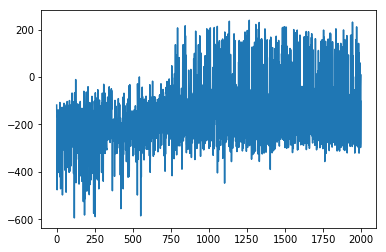

In [9]:
plt.plot(scores)

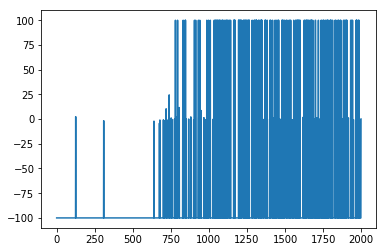

In [10]:
plt.plot(final_rewards)

In [11]:
ten_scores = []

c = 0
acc = 0

for s in scores:
    if c % 10 == 0:
        ten_scores.append(acc)
        acc = 0
    
    acc += s
    c += 1

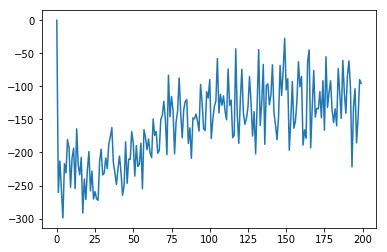

In [12]:
plt.plot(np.array(ten_scores) / 10)

In [13]:
torch.save(dqn.model.state_dict(), './checkpoint_2k.pth')

In [ ]:
# this breaks the kernel
# moved out to it's own notebook for now

# from gym.wrappers import Monitor

# video_env = Monitor(env, './test_video', force=True)

# state = video_env.reset()
# done = False
# while not done:
# #     video_env.render()
# #     video_env.render(close=True)
#     action = np.argmax(dqn.predict(state))
#     state, reward, done, info = video_env.step(action)
# #     print(reward)